In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import simtk.openmm as mm
from torsionfit import TorsionScanSet as ScanSet
import torsionfit.TorsionFitModel as Model
from torsionfit import sqlite_plus
from pymc import MCMC
from parmed.charmm import CharmmParameterSet
from torsionfit import plots
from matplotlib.backends.backend_pdf import PdfPages

/Users/chayastern/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
param_to_opt=[('CG331', 'CG321', 'CG321', 'CG331')]
param = CharmmParameterSet('../data/charmm_ff/top_all36_cgenff.rtf', '../data/charmm_ff/par_all36_cgenff.prm')
structure = 'structure/butane.psf'
scan = 'MP2_torsion_scan/'
# Print initial guess
print param.dihedral_types[param_to_opt[0]]
# Turn off torsion
param.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][1].phi_k=0
param.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][0].phi_k=0


<DihedralTypes [<DihedralType; phi_k=0.038, per=2, phase=0.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=0.032, per=6, phase=180.000,  scee=1.000, scnb=1.000>]>


In [3]:
butane_scan = ScanSet.parse_psi4_out(scan, structure)
butane_scan.compute_energy(param)

[Psi /Users/chayastern/src/ChayaSt/Torsions/examples/butane/MP2_torsion_scan/0/butane_0.out2 WARNING] In logfileparser.py, line 467, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/chayastern/src/ChayaSt/Torsions/examples/butane/MP2_torsion_scan/10/butane_10.out2 WARNING] In logfileparser.py, line 467, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/chayastern/src/ChayaSt/Torsions/examples/butane/MP2_torsion_scan/20/butane_20.out2 WARNING] In logfileparser.py, line 467, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/chayastern/src/ChayaSt/Torsions/examples/butane/MP2_torsion_scan/30/butane_30.out2 WARNING] In logfileparser.py, line 467, line not all dashes as expected: ------------------------------------------

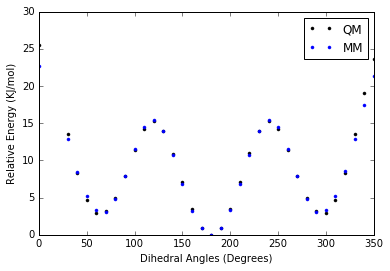

In [4]:
optimized = butane_scan.remove_nonoptimized()
optimized.compute_energy(param)

plt.plot(optimized.steps, optimized.qm_energy, 'k.', label='QM')
plt.plot(optimized.steps, optimized.mm_energy, '.', label='MM')
plt.xlabel('Dihedral Angles (Degrees)')
plt.ylabel('Relative Energy (KJ/mol)')
plt.legend()

In [5]:
platform = mm.Platform.getPlatformByName('Reference')
model = Model.TorsionFitModelEliminatePhase(param, optimized, platform=platform, decouple_n=True, 
                                            param_to_opt=param_to_opt)
sampler = MCMC(model.pymc_parameters, db=sqlite_plus, dbname='butane_decouple_n.database', verbose=5)

In [6]:
sampler.sample(10000)

Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_4_K
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_1_K
Assigning step method Metropolis to stochastic BUTA1_offset
Assigning step method DiscreteMetropolis to stochastic CG331_CG321_CG321_CG331_multiplicity_bitstring
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_6_K
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_2_K
Assigning step method Metropolis to stochastic log_sigma
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_3_K
 [-----------------100%-----------------] 10001 of 10000 complete in 483.8 sec

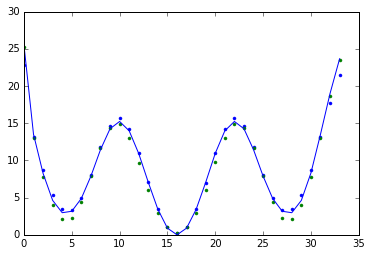

In [7]:
plt.plot(sampler.trace('mm_energy')[0], 'b.')
plt.plot(optimized.mm_energy, 'g.')
plt.plot(optimized.qm_energy)

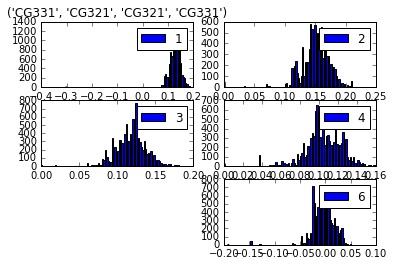

In [8]:
db = sqlite_plus.load('butane_decouple_n.database')
multiplicities = ['1', '2', '3', '4', '6']
with PdfPages('param_hist_decouple_n_init0.pdf') as pdf:
    for torsion in param_to_opt:
        torsion_name = torsion[0] + '_' + torsion[1] + '_' + torsion[2] + '_' + torsion[3]
        for n, m in enumerate(multiplicities):
            if n==1:
                plt.title(torsion)
            plt.subplot(3, 2, int(m))
            k = torsion_name + '_' + m + '_K'
            plt.hist(getattr(db, k)[:], bins=100, label=m)
            plt.legend()
        pdf.savefig()
        plt.show()
        plt.close()

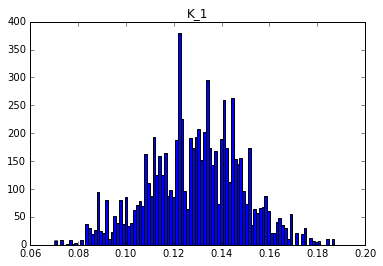

In [9]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_1_K')[2000:], bins=100)
plt.title('K_1')

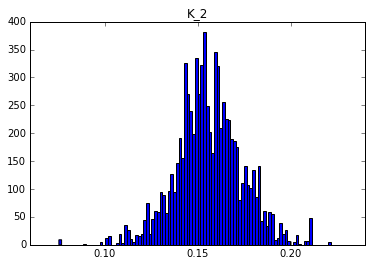

In [10]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_2_K')[2000:], bins=100)
plt.title('K_2')

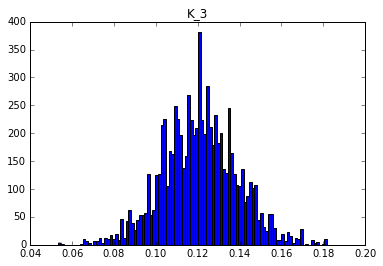

In [11]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_3_K')[2000:], bins=100)
plt.title('K_3')

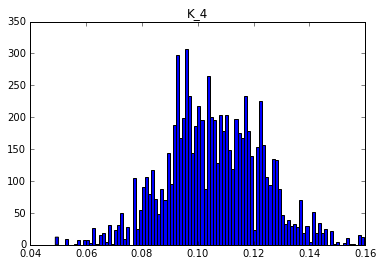

In [12]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_4_K')[2000:], bins=100)
plt.title('K_4')

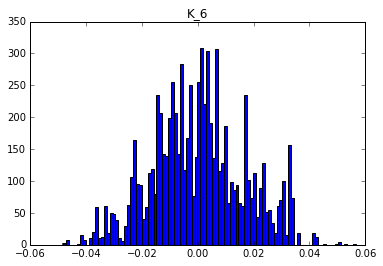

In [13]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_6_K')[2000:], bins=100)
plt.title('K_6')

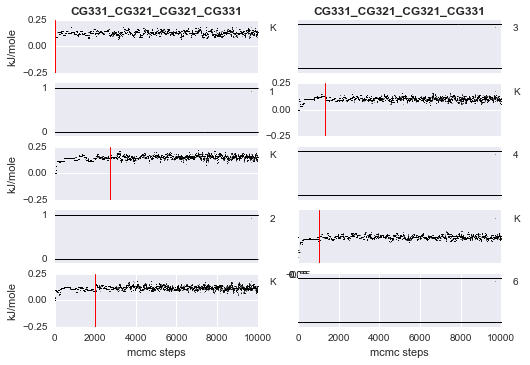

In [2]:
import seaborn
db = sqlite_plus.load('butane_decouple_n.database')
plots.trace_no_phase('CG331_CG321_CG321_CG331', db, markersize=1.0, ymin=-0.25, ymax=0.25, 
                     filename='trace_decouple_n_init_0.pdf')

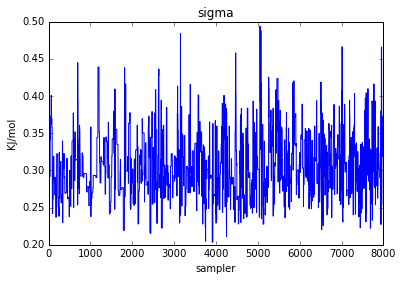

In [14]:
import numpy as np
plt.plot(np.exp(sampler.log_sigma.trace[2000:]))
plt.title('sigma')
plt.xlabel('sampler')
plt.ylabel('KJ/mol')
plt.savefig('sigma_decouple_n.png')